# Set up

In [23]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
from matplotlib.path import Path
import math
from pycocotools import mask as maskUtils
import glob
np.set_printoptions(precision=15)
import albumentations as A
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.cuda.set_device(3) # can save errors 

import class_agnostic_sam_predictor, dataset, losses
from class_agnostic_sam_predictor import predictor_utils as predict
from dataset import dataset_utils, augment, astronomy_utils as astro
from losses import loss as loss

# Dataset split

You can choose to manually split your dataset here (if you don't have (at least) train/val splits locally). Otherwise, you should set this variable to `False`. All masks are converted to Run Length Enconding (RLE) format for computational efficiency, especially given that many masks are small.

In [2]:
split_dataset_here = True

In [3]:
input_dir = './roboflow_datasets/xmm_om_artefacts_512-7-COCO/'

In [4]:
if split_dataset_here:
    input_dir = input_dir+'train/'
    json_file_path = input_dir+'_annotations.coco.json'
    
    # COCO segmentation bboxes are in XYWH format
    with open(json_file_path) as f:
        data = json.load(f)

    # gt masks are converted to RLE here
    ground_truth_masks, bbox_coords, classes, class_categories = dataset_utils.get_coords_and_masks_from_json(input_dir, data) # type: ignore

    # check if some images lack annotations due to eventual filtering by mask size or classes (this usually doesn't happen)
    raw_images = [input_dir+img_data['file_name'] for img_data in data['images']]
    training_size, val_size, test_size = (0.8, 0.2, 0.0)
    splits = dataset_utils.split_list(raw_images, [training_size, val_size, test_size])
    training_image_paths, val_image_paths, test_image_paths = splits[0], splits[1], splits[2]
    train_gt_masks, train_bboxes = dataset_utils.create_dataset(training_image_paths, ground_truth_masks, bbox_coords)
    test_gt_masks, test_bboxes = dataset_utils.create_dataset(test_image_paths, ground_truth_masks, bbox_coords)
    val_gt_masks, val_bboxes = dataset_utils.create_dataset(val_image_paths, ground_truth_masks, bbox_coords)
    train_dir = valid_dir = input_dir
    
    del ground_truth_masks, bbox_coords

else: # assume you already have a train/val/test split directory
    train_dir = input_dir+'/train/'
    valid_dir = input_dir+'valid/'
    test_dir =  input_dir+'test/' # in case test split is also available
    json_train_path, json_valid_path, json_test_path = train_dir+'_annotations.coco.json', valid_dir+'_annotations.coco.json', test_dir+'_annotations.coco.json'
    
    training_image_paths = [train_dir+filename for filename in os.listdir(train_dir) 
                            if any(filename.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg']) ]
    val_image_paths = [valid_dir+filename for filename in os.listdir(valid_dir) 
                       if any(filename.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg']) ]
    test_image_paths = [test_dir+filename for filename in os.listdir(test_dir) 
                        if any(filename.lower().endswith(ext) for ext in ['.png', '.jpg', '.jpeg']) ]
    
    train_data = dataset_utils.load_json(json_train_path)
    valid_data = dataset_utils.load_json(json_valid_path)
    test_data = dataset_utils.load_json(json_test_path)
        
    train_gt_masks, train_bboxes, train_classes, train_class_categories = dataset_utils.get_coords_and_masks_from_json(train_dir, train_data) # type: ignore
    val_gt_masks, val_bboxes, val_classes, val_class_categories = dataset_utils.get_coords_and_masks_from_json(valid_dir, valid_data) # type: ignore
    test_gt_masks, test_bboxes, test_classes, test_class_categories = dataset_utils.get_coords_and_masks_from_json(test_dir, test_data) # type: ignore

In [5]:
print('# dataset images: \ntrain', len(training_image_paths), '\nvalid', len(val_image_paths), '\ntest', len(test_image_paths))

# dataset images: 
train 550 
valid 137 
test 0


**Visualize annotations**

S0677700131_L_png.rf.c609cf4e5c9899a4732b464f02d3b7a8.jpg


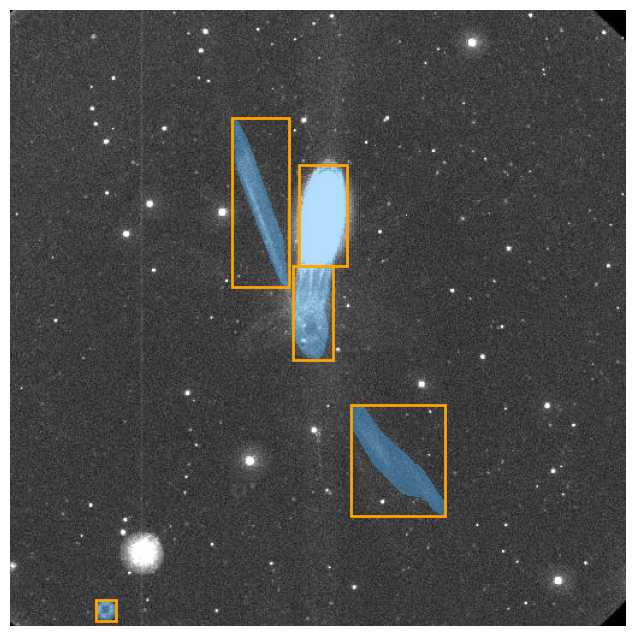

S0801680101_L_png.rf.c3b7270657523213ad92f6be78448461.jpg


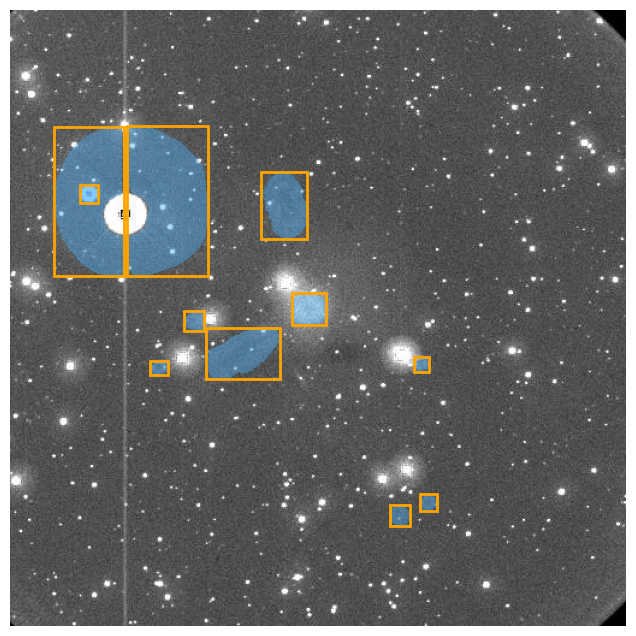

S0102640701_V_png.rf.c68406eb7ca1cc40369eb84ff902d99c.jpg


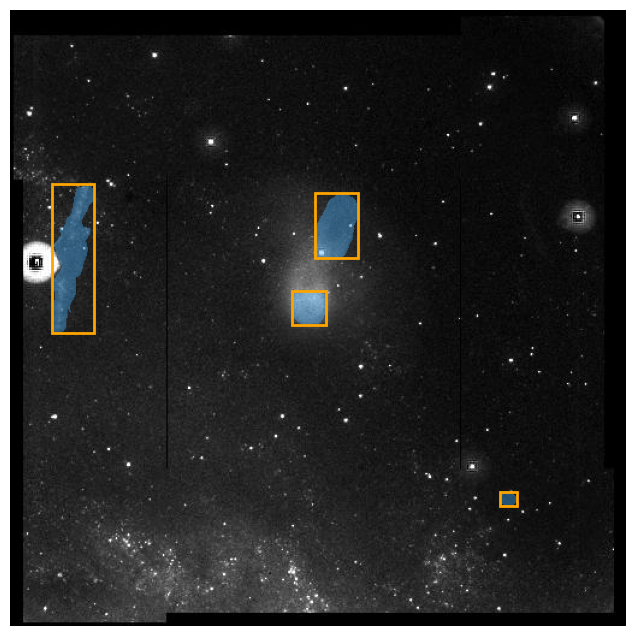

S0822050101_S_png.rf.c3fdd652bdef17bf089d7c067cb1d207.jpg


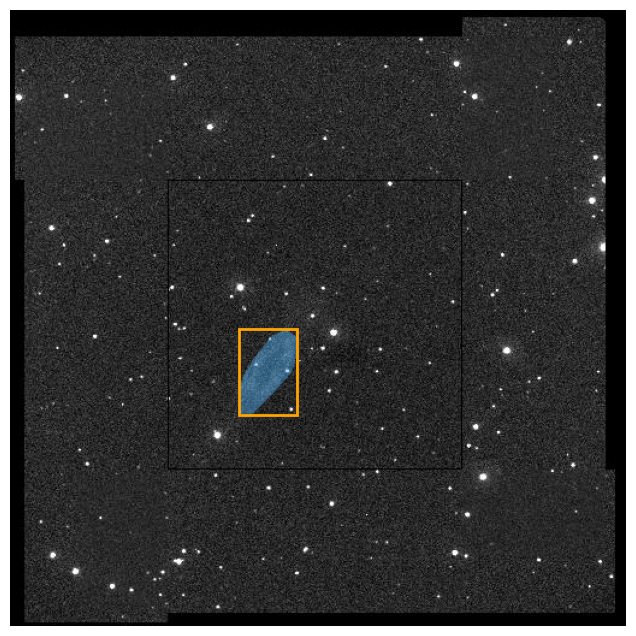

In [6]:
for one_path in training_image_paths[:4]:
    image_id2 = one_path.split('/')[-1]
    print(image_id2)
    image_masks_ids = [key for key in train_gt_masks.keys() if key.startswith(image_id2)]
    image_ = cv2.imread(one_path)
    image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(image_)
    for name in image_masks_ids:
        dataset_utils.show_box(train_bboxes[name], plt.gca())
        dataset_utils.show_mask(maskUtils.decode(train_gt_masks[name]), plt.gca())
    plt.axis('off')
    plt.show()
    plt.close()

# Augmentation

This algorithm performs augmentations on the training set and updates the negative masks in the case of a geometric transformations. Otherwise, it masks the result of a noise/blur transformation given the mask of the initial image. 

📍 For augmentation, the bboxes are expected to be in the XYWH format, not XYXY format (used by SAM). However, the SAM AMG generated results are in the XYWH format (converted from XYXY).


In [7]:
use_augmentation = False # set this to False if you already have an augmented dataset

if use_augmentation: 
    import albumentations as A
    
    # remove augmented images possibly resulted from a previous augmentation run
    files = glob.glob(f'{input_dir}/*augm*')
    
    for file in files:
        os.remove(file)

    geometrical_augmentations = A.Compose([
        A.Flip(),
        A.RandomRotate90(),
        A.RandomSizedCrop((512 - 50, 512 - 50), 512, 512),
    ], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)
    
    noise_blur_augmentations = A.Compose([
        A.GaussianBlur(blur_limit=(3, 3), p=0.6),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.8),
        A.ISONoise(p=0.8),
    ], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

    image_paths = []
    training_paths_cpy = np.copy(training_image_paths)
    for image_path in training_paths_cpy:
        image_paths.append(image_path)
        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_size = (image_.shape[0], image_.shape[1])
        masks = [maskUtils.decode(value_i) for key_i, value_i in train_gt_masks.items() if key_i.startswith(image_path.split('/')[-1])]
        bboxes_ = [augment.enlarge_bbox(np.array([value_i[0], math.floor(value_i[1]),  math.floor(value_i[2] - value_i[0]), \
                                        math.floor(value_i[3] - value_i[1])]), 0.5, image_size) \
                                        for key_i, value_i in train_bboxes.items() if key_i.startswith(image_path.split('/')[-1])]
        label_ids = [classes[key_i] for key_i, value_i in train_bboxes.items() if key_i.startswith(image_path.split('/')[-1])]
    
        image_size = (image_.shape[0], image_.shape[1])

        if len(bboxes_) == 0:
            print(f'{image_path} has no bounding boxes.')
            continue
                    
        for bbox in bboxes_:
            if bbox[2] <= 1 or bbox[3] <= 1:
                print("Invalid bbox detected:", bbox)
            
        if len(bboxes_) != len(masks):
            print('len(bboxes_) != len(masks)', len(bboxes_), len(masks))
            continue
    
        if len(bboxes_) != len(label_ids):
            print('len(bboxes_) != len(label_ids)', len(bboxes_), len(label_ids))
            continue
            
        img_negative_mask = (image_>0).astype(int)
        
        # the geometrical augm doesn't change the shape of the image
        augmented1 = augment.augment_and_show(
            geometrical_augmentations, 
            image_, 
            masks, 
            bboxes_, 
            label_ids, 
            class_categories, 
            show_=False)
        new_image_negative_mask = (augmented1['image']>0).astype(int) # to mask the transform which is derived from the geometric transform
        augmented3 = augment.augment_and_show(
            noise_blur_augmentations, 
            image_, 
            masks, 
            bboxes_, 
            label_ids, 
            class_categories, 
            show_=False)
    
        # mask the transform using the image negative mask
        augmented3['image'] = augmented3['image'] * img_negative_mask
            
        new_filename1 = image_path.replace('.'+image_path.split('.')[-1], '_augm1.jpg')
        new_filename3 = image_path.replace('.'+image_path.split('.')[-1], '_augm3.jpg')

        if len(augmented1['bboxes']) != len(augmented1['masks']):
            print('Augment 1: len(bboxes_) != len(masks)', len(augmented1['bboxes']), len(augmented1['masks']))
        if len(augmented3['bboxes']) != len(augmented3['masks']):
            print('Augment 2: len(bboxes_) != len(masks)', len(augmented3['bboxes']), len(augmented3['masks']))
    
        augment.update_dataset_with_augms(augmented1, new_filename1, train_bboxes, train_gt_masks, training_image_paths, classes)
        augment.update_dataset_with_augms(augmented3, new_filename3, train_bboxes, train_gt_masks, training_image_paths, classes)
else:
    image_paths = training_image_paths + val_image_paths + test_image_paths
    train_dir = input_dir
    valid_dir = input_dir

**dataset distribution**

In [8]:
from PIL import Image
import numpy as np

means = []
stds = []

for image_path in image_paths:
    image = Image.open(image_path)

    image_array = np.array(image) / 255.0

    mean = image_array.mean()
    std = image_array.std()

    means.append(mean)
    stds.append(std)

means = np.array(means)
stds = np.array(stds)

In [9]:
np.mean(means), np.std(means)

(0.14563629412129137, 0.11978658043561993)

In [10]:
np.mean(stds),np.std(stds)

(0.1015505337135735, 0.03380705830252881)

## 🚀 Prepare Mobile SAM Fine Tuning

In [11]:
# !nvidia-smi

In [12]:
import sys
import PIL
from PIL import Image
sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
from ft_mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/weights/mobile_sam.pt"
mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/weights/mobile_sam.pt"

# mobile_sam_checkpoint = "./ft_mobile_sam_final.pth"
device = "cuda:3" if torch.cuda.is_available() else "cpu"
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device);
print("DEVICE", device)

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

DEVICE cuda:3


In [13]:
use_wandb = False

if use_wandb:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="OM_AI_v1", name=f"ft_MobileSAM {datetime.now()}")

    wandb.watch(mobile_sam_model, log='all', log_graph=True)

## Convert the input images into a format SAM's internal functions expect.

In [14]:
# Preprocess the images
import os
from collections import defaultdict
import torch
import segment_anything
from segment_anything.utils.transforms import ResizeLongestSide
from torchvision.transforms.functional import resize

transform = ResizeLongestSide(mobile_sam_model.image_encoder.img_size)

def transform_image(image, k):
       
        # sets a specific mean for each image
        image_T = np.transpose(image, (2, 1, 0))
        mean_ = np.mean(image_T[image_T>0])
        std_ = np.std(image_T[image_T>0]) 
        pixel_mean = torch.as_tensor([mean_, mean_, mean_], dtype=torch.float, device=device)
        pixel_std = torch.as_tensor([std_, std_, std_], dtype=torch.float, device=device)

        mobile_sam_model.register_buffer("pixel_mean", torch.Tensor(pixel_mean).unsqueeze(-1).unsqueeze(-1), False) # not in SAM
        mobile_sam_model.register_buffer("pixel_std", torch.Tensor(pixel_std).unsqueeze(-1).unsqueeze(-1), False) # not in SAM

        transformed_data = {}
        negative_mask = np.where(image > 0, True, False)
        negative_mask = torch.from_numpy(negative_mask)  
        negative_mask = negative_mask.permute(2, 0, 1)
        negative_mask = resize(negative_mask, [1024, 1024], antialias=True) 
        negative_mask = negative_mask.unsqueeze(0)
        # scales the image to 1024x1024 by longest side 
        input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        
        # normalization and padding
        input_image = mobile_sam_model.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])
        input_image[~negative_mask] = 0
        transformed_data['image'] = input_image.clone() 
        transformed_data['input_size'] = input_size 
        transformed_data['image_id'] = k
        transformed_data['original_image_size'] = original_image_size
    
        return transformed_data

In [15]:
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_paths, bbox_coords, gt_masks, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_id = self.image_paths[idx].split("/")[-1]
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

        if self.transform is not None:
            return self.transform(image, img_id)
        else:
            print("❗️No transform❗️")
            return image
        
batch_size = 8

train_set = ImageDataset(training_image_paths[:10], train_bboxes, train_gt_masks, transform_image) 
val_set = ImageDataset(val_image_paths[:10], val_bboxes, val_gt_masks, transform_image) 
test_set = ImageDataset(test_image_paths, test_bboxes, test_gt_masks, transform_image) 

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [16]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import torch.nn as nn

lr=6e-5
wd=0.0005
loss_scaling_factor = 1e5 # this factor is used to save some very small gradients 

parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) #loss_scale_factor=1e5
predictor = SamPredictor(mobile_sam_model)

## Model weights

In [17]:
for name, param in mobile_sam_model.named_parameters():
    if 'mask_decoder' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [18]:
def check_requires_grad(model, show=True):
    for name, param in model.named_parameters():
        if param.requires_grad and show:
            print("✅ Param", name, " requires grad.")
        elif param.requires_grad == False:
            print("❌ Param", name, " doesn't require grad.")

In [19]:
print(f"🚀 The model has {sum(p.numel() for p in mobile_sam_model.parameters() if p.requires_grad)} trainable parameters.\n")
check_requires_grad(mobile_sam_model)

🚀 The model has 4058340 trainable parameters.

❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weigh

## Run fine tuning

In [24]:
def one_image_predict_transform(
    transformed_image, 
    transformed_bboxes, 
    transformed_mask,
    original_image_size,
    device):

    image_loss=[]
    gt_rle_to_masks, mask_areas = [], []
    image_embedding = model.image_encoder(transformed_image)

    for k in range(len(transformed_mask)): 
        prompt_box = np.array(transformed_bboxes[k])
        box = predictor.transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        boxes.append(box_torch)

        # process masks
        rle_to_mask = maskUtils.decode(gt_masks[k]) # RLE to array
        gt_rle_to_masks.append(torch.from_numpy(rle_to_mask).to(device))
 
    boxes = torch.stack(boxes, dim=0)
    gt_rle_to_masks = torch.stack(gt_rle_to_masks, dim=0)
    
    sparse_embeddings, dense_embeddings = model.prompt_encoder(
      points=None,
      boxes=boxes,
      masks=None, 
    )

    del box_torch
    torch.cuda.empty_cache()
    
    low_res_masks, iou_predictions = model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False, # True value works better for ambiguous prompts (single points)
    )

    # plt.imshow(low_res_masks[0][0].detach().cpu().numpy())
    # plt.show()
    # plt.close()
    
    pred_masks = model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    threshold_mask = torch.sigmoid(pred_masks - model.mask_threshold)
    gt_threshold_mask = torch.as_tensor(gt_rle_to_masks>0.5, dtype=torch.float32) 
    numpy_gt_threshold_mask = gt_threshold_mask.contiguous().detach().cpu().numpy()
    mask_result = torch.squeeze(threshold_mask, dim=1).detach().cpu().numpy()

    # compute weighted dice loss (smaller weights on smaller objects)
    focal = loss.focal_loss_per_mask_pair(torch.squeeze(pred_masks, dim=1), gt_threshold_mask, mask_areas)
    dice = loss.dice_loss_per_mask_pair(torch.squeeze(threshold_mask, dim=1), gt_threshold_mask, mask_areas, negative_mask) 
    image_loss.append(20 * focal + dice ) # used in SAM paper
    
    del threshold_mask
    del numpy_gt_threshold_mask 
    del low_res_masks, iou_predictions 
    del pred_masks, gt_threshold_mask
    del rle_to_mask
    torch.cuda.empty_cache()

    image_loss = torch.stack(image_loss)
    image_loss = torch.mean(image_loss) 
    
    # fig, axs = plt.subplots(1, 3, figsize=(40, 20))
    # axs[0].imshow(input_image) 
    # axs[0].set_title(f'{k.split(".")[0]}', fontsize=40)
    
    # axs[1].imshow(input_image)
    # dataset_utils.show_masks(mask_result, axs[1], random_color=False)
    # axs[1].set_title('Predicted masks', fontsize=40)
    
    # axs[2].imshow(input_image) 
    # dataset_utils.show_masks(gt_rle_to_masks.detach().cpu().numpy(), axs[2], random_color=False)
    # axs[2].set_title('Ground truth masks', fontsize=40)
    
    # plt.show()
    # plt.close()

    return image_loss

In [31]:
def one_image_predict(
    image_masks, 
    gt_masks, 
    gt_bboxes, 
    image_embedding, 
    original_image_size, 
    input_size, 
    negative_mask, 
    input_image, 
    model,
    cr_transforms):
    
    image_loss=[]
    boxes, masks, coords, coords_labels = [], [], [], []
    gt_rle_to_masks, mask_areas = [], []
    
    for k in image_masks: 
        prompt_box = np.array(gt_bboxes[k])
        box = predictor.transform.apply_boxes(prompt_box, original_image_size)
        box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
        boxes.append(box_torch)

        # process masks
        rle_to_mask = maskUtils.decode(gt_masks[k]) # RLE to array
        gt_rle_to_masks.append(torch.from_numpy(rle_to_mask).to(device))
        mask_input_torch = torch.as_tensor(rle_to_mask, dtype=torch.float, device=predictor.device).unsqueeze(0)
        mask_input_torch = F.interpolate(
            mask_input_torch.unsqueeze(0), 
            size=(256, 256), 
            mode='bilinear', 
            align_corners=False)
        masks.append(mask_input_torch.squeeze(0))
        mask_areas.append(np.sum(rle_to_mask))

        # process coords and labels
        x_min, y_min, x_max, y_max = gt_bboxes[k]
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        point_coords = np.array([(gt_bboxes[k][2]+gt_bboxes[k][0])/2.0, (gt_bboxes[k][3]+gt_bboxes[k][1])/2.0])
        point_labels = np.array([1])
        point_coords = predictor.transform.apply_coords(point_coords, original_image_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=predictor.device).unsqueeze(0)
        labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=predictor.device)
        coords.append(coords_torch)
        coords_labels.append(labels_torch)

    boxes = torch.stack(boxes, dim=0)
    masks = torch.stack(masks, dim=0)
    coords = torch.stack(coords, dim=0)
    coords_labels = torch.stack(coords_labels, dim=0)
    points = (coords, coords_labels)
    gt_rle_to_masks = torch.stack(gt_rle_to_masks, dim=0)
    
    sparse_embeddings, dense_embeddings = model.prompt_encoder(
      points=None,
      boxes=boxes,
      masks=None, 
    )

    del box_torch, coords_torch, labels_torch
    torch.cuda.empty_cache()
    
    low_res_masks, iou_predictions = model.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=model.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False, # True value works better for ambiguous prompts (single points)
    )

    # plt.imshow(low_res_masks[0][0].detach().cpu().numpy())
    # plt.show()
    # plt.close()
    
    pred_masks = model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    threshold_mask = torch.sigmoid(pred_masks - model.mask_threshold)
    gt_threshold_mask = torch.as_tensor(gt_rle_to_masks>0.5, dtype=torch.float32) 
    numpy_gt_threshold_mask = gt_threshold_mask.contiguous().detach().cpu().numpy()
    mask_result = torch.squeeze(threshold_mask, dim=1).detach().cpu().numpy()

    # compute weighted dice loss (smaller weights on smaller objects)
    focal = loss.focal_loss_per_mask_pair(torch.squeeze(pred_masks, dim=1), gt_threshold_mask, mask_areas)
    dice = loss.dice_loss_per_mask_pair(torch.squeeze(threshold_mask, dim=1), gt_threshold_mask, mask_areas, negative_mask) 
    image_loss.append(20 * focal + dice ) # used in SAM paper

    # Apply consistency regulation
    if cr_transforms:
        for cr_transform in cr_transforms:
            transformed = cr_transform(
                image=input_image, 
                bboxes=boxes.detach().cpu().numpy(), 
                masks=gt_rle_to_masks.detach().cpu().numpy(),
                category_id=[0] * len(bboxes)) #  I don't have labels for the moment 
            
            transformed_image = transformed['image']
            transformed_bboxes = transformed['bboxes']
            transformed_masks = transformed['masks']
            tranformed_loss = one_image_predict_transform(
                transformed_image, 
                transformed_bboxes, 
                transformed_mask,
                original_image_size, 
                device)

    del threshold_mask
    del numpy_gt_threshold_mask 
    del low_res_masks, iou_predictions 
    del pred_masks, gt_threshold_mask
    del rle_to_mask
    torch.cuda.empty_cache()

    image_loss = torch.stack(image_loss)
    image_loss = torch.mean(image_loss) #* loss_scaling_factor
    
    # fig, axs = plt.subplots(1, 3, figsize=(40, 20))
    # axs[0].imshow(input_image) 
    # axs[0].set_title(f'{k.split(".")[0]}', fontsize=40)
    
    # axs[1].imshow(input_image)
    # dataset_utils.show_masks(mask_result, axs[1], random_color=False)
    # axs[1].set_title('Predicted masks', fontsize=40)
    
    # axs[2].imshow(input_image) 
    # dataset_utils.show_masks(gt_rle_to_masks.detach().cpu().numpy(), axs[2], random_color=False)
    # axs[2].set_title('Ground truth masks', fontsize=40)
    
    # plt.show()
    # plt.close()

    return image_loss

In [32]:
import torch
import numpy as np
from tqdm import tqdm

def train_validate_step(model, 
                        dataloader, 
                        input_dir, 
                        gt_masks, 
                        gt_bboxes, 
                        device, 
                        optimizer=None, 
                        mode='train',
                        cr_transforms = None):
    assert mode in ['train', 'validate'], "Mode must be 'train' or 'validate'"
    losses = []

    for inputs in tqdm(dataloader, desc=f'{mode[0].upper()+mode[1:]} Progress', bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        batch_loss = 0.0
        batch_size = len(inputs['image']) # sometimes, at the last iteration, there are fewer images than batch size
        for i in range(batch_size):
            image_masks = [k for k in gt_masks.keys() if k.startswith(inputs['image_id'][i])]
            input_image = torch.as_tensor(inputs['image'][i], dtype=torch.float, device=predictor.device) # (B, C, 1024, 1024)
            image = cv2.imread(input_dir+inputs['image_id'][i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_image_size = image.shape[:-1]
            input_size = (1024, 1024)

            # IMAGE ENCODER
            image_embedding = model.image_encoder(input_image)
               
            # negative_mask has the size of the image
            negative_mask = np.where(image>0, True, False)
            negative_mask = torch.from_numpy(negative_mask)  
            negative_mask = negative_mask.permute(2, 0, 1)
            negative_mask = negative_mask[0]
            negative_mask = negative_mask.unsqueeze(0).unsqueeze(0)
            negative_mask = negative_mask.to(device)
            
            # RUN PREDICTION ON IMAGE
            if len(image_masks)>0:
                batch_loss += (one_image_predict(image_masks, gt_masks, gt_bboxes, image_embedding, 
                                                 original_image_size, input_size, negative_mask, image, model, cr_transforms)) 
            else:
                print(f"{inputs['image_id'][i]} has no annotations❗️")
        if mode == 'train':
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            del image_embedding, negative_mask, input_image, image
            torch.cuda.empty_cache()

        losses.append(batch_loss.item()/batch_size) #/loss_scaling_factor)
            
    return np.mean(losses), model

In [34]:
import matplotlib.patches as patches

train_losses = []
valid_losses = []
num_epochs = 30
best_valid_loss = float('inf')
n_epochs_stop = num_epochs/3

geometrical_augmentations = A.Compose([
        A.Flip(),
        A.RandomRotate90(),
        A.RandomSizedCrop((512 - 50, 512 - 50), 512, 512),
    ], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)
    
noise_blur_augmentations = A.Compose([
        A.GaussianBlur(blur_limit=(3, 3), p=0.6),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.8),
        A.ISONoise(p=0.8),
    ], bbox_params={'format':'coco', 'min_area': 0.1, 'min_visibility': 0.3, 'label_fields': ['category_id']}, p=1)

cr_transforms = [geometrical_augmentations, noise_blur_augmentations]

for epoch in range(num_epochs):

    # train
    mobile_sam_model.train()
    epoch_loss, model = train_validate_step(
        mobile_sam_model, 
        train_dataloader, 
        train_dir, 
        train_gt_masks, 
        train_bboxes, 
        device, 
        optimizer, 
        mode='train',
        cr_transforms = cr_transforms)
    train_losses.append(epoch_loss)
    
    # validate
    mobile_sam_model.eval()
    with torch.no_grad():
        epoch_val_loss, model = train_validate_step(
            mobile_sam_model, 
            val_dataloader, 
            valid_dir, 
            val_gt_masks, 
            val_bboxes, 
            device, 
            optimizer, 
            mode='validate',
        cr_transforms = None)
            
        valid_losses.append(epoch_val_loss)
        
        if epoch_val_loss < best_valid_loss:
            best_valid_loss = epoch_val_loss
            best_model = model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping initiated.")
                early_stop = True
                break

    # # Logging
    if use_wandb:
        wandb.log({'epoch training loss': epoch_loss, 'epoch validation loss': epoch_val_loss})

    print(f'EPOCH: {epoch}. Training loss: {epoch_loss}')
    print(f'EPOCH: {epoch}. Validation loss: {epoch_val_loss}.')

torch.save(best_model.state_dict(), f'ft_mobile_sam_final.pth')

if use_wandb:
    wandb.run.summary["batch_size"] = batch_size
    wandb.run.summary["num_epochs"] = num_epochs
    wandb.run.summary["learning rate"] = lr
    wandb.run.summary["weight_decay"] = wd
    wandb.run.summary["loss_scaling_factor"] = loss_scaling_factor
    wandb.run.summary["# train images"] = len(train_dataloader.dataset)
    wandb.run.summary["# validation images"] = len(val_dataloader.dataset)
    wandb.run.summary["checkpoint"] = mobile_sam_checkpoint

    run.finish()

Train Progress:   0%|          | 0/69 [00:00<?, ?it/s]                                                                                                                                                      


ValueError: Please specify 'label_fields' in 'bbox_params' or add labels to the end of bbox because bboxes must have labels

In [ ]:
import sys
import PIL
from PIL import Image

check_orig = False
if check_orig:
    sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-master/')
    import mobile_sam
    from mobile_sam import sam_model_registry as orig_mobile_sam_model_registry, \
                           SamPredictor as orig_mobile_SamPredictor
    
    # orig_mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/XMM_OM_code_git/ft_mobile_sam_final.pth"
    orig_mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-master/weights/mobile_sam.pt"
    orig_mobile_sam_model = orig_mobile_sam_model_registry["vit_t"](checkpoint=orig_mobile_sam_checkpoint)
    orig_mobile_sam_model.to(device);
    orig_mobile_sam_model.eval();
    
    mobile_sam_model.eval();
    predictor = orig_mobile_SamPredictor(mobile_sam_model)
    
    valid_losses = []
    with torch.no_grad():
        epoch_val_loss, _ = train_validate_step(
            mobile_sam_model, 
            val_dataloader, 
            valid_dir, 
            val_gt_masks, 
            val_bboxes, 
            device, 
            optimizer, 
            mode='validate')
        valid_losses.append(epoch_val_loss)
    print(f'EPOCH: {epoch}. Validation loss: {epoch_val_loss}.')

In [ ]:
# from IPython.display import display
# display(dot)

In [ ]:
# import json
# import graphviz

# json_file_path = './graph_0_summary_598a07b5e588b04c9de6.graph.json'

# with open(json_file_path, 'r') as file:
#     model_data = json.load(file)

# dot = graphviz.Digraph(comment='Model Visualization')

# for node in model_data['nodes']:
#     label = f"{node['name']}\n{node['class_name']}"
#     dot.node(str(node['id']), label=label)
# dot.render('output', view=False)

In [ ]:
# plt.plot(list(range(len(losses))), losses)
# plt.title('Mean epoch loss \n mask with sigmoid')
# plt.xlabel('Epoch Number')
# plt.ylabel('Loss')
# plt.savefig('loss_mask_sigmoid_training.png')
# plt.show()
# plt.close()